In [1]:
import atlite
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import pandas as pd

In [2]:
# Load hydropower plant and hydrobasin data
location_hydro = gpd.read_file(f'Data_30/hydropower_dams_30.gpkg')
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
location_hydro.rename(columns={'head_example': 'head'}, inplace=True)

laos_hydrobasins = gpd.read_file('Data_hydrobasins/hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
laos_hydrobasins['lat'] = location_hydro.geometry.y
laos_hydrobasins['lon'] = location_hydro.geometry.x


### Visualisation of capacity factors

In [3]:
from scipy.constants import physical_constants

def hydropower_potential(eta,flowrate,head):
    '''
    Calculate hydropower potential in Megawatts

    Parameters
    ----------
    eta : float
        Efficiency of the hydropower plant.
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.

    Returns
    -------
    float
        Hydropower potential in Megawatts (MW).
    '''
    rho = 997 # kg/m3; Density of water
    g = physical_constants['standard acceleration of gravity'][0] # m/s2; Based on the CODATA constants 2018
    Q = (flowrate/(1000/24)) / 3600 # transform flowrate per h into flowrate per second
    return (eta * rho * g * Q * head) / (1000 * 1000) # MW

def hydropower_potential_with_capacity(flowrate, head, capacity, eta):
    '''
    Calculate the hydropower potential considering the capacity limit

    Parameters
    ----------
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.
    capacity : float
        Maximum hydropower capacity in Megawatts (MW).
    eta : float
        Efficiency of the hydropower plant.

    Returns
    -------
    xarray DataArray
        Capacity factor, which is the limited potential divided by the capacity.
    '''
    potential = hydropower_potential(flowrate, head, eta)
    limited_potential = xr.where(potential > capacity, capacity, potential)
    capacity_factor = limited_potential / capacity
    return capacity_factor

runoff = xr.open_dataarray("Cutouts_atlite/Laos5AVG_Runoff_30.nc")
location_hydro = gpd.read_file(f'Data_30/hydropower_dams_30.gpkg')


eta = 0.75  # efficiency of hydropower plant
capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    runoff,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['Total capacity (MW)'].values, dims=['plant']),
    eta,
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

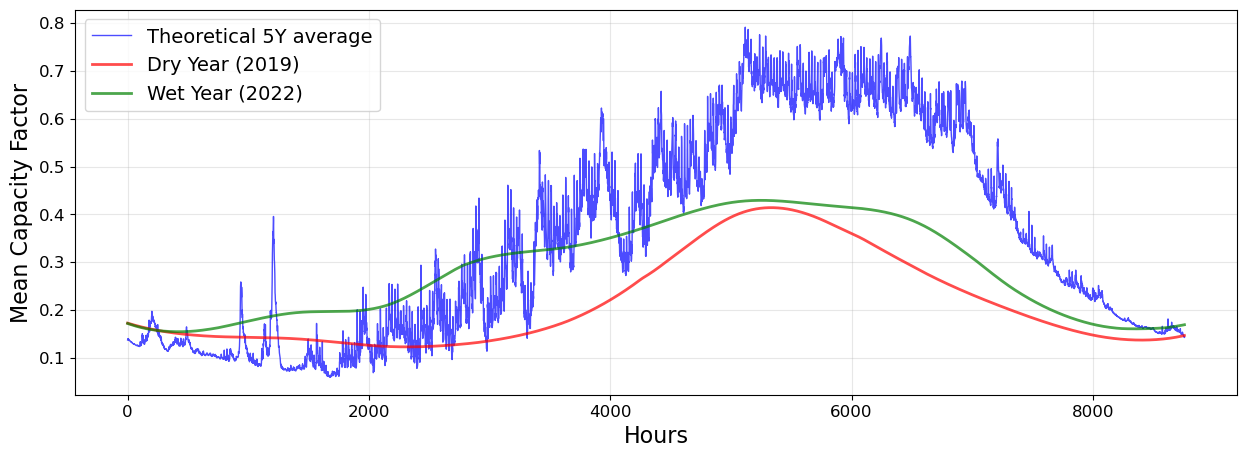

In [4]:
# Load data
dry = xr.open_dataset('Cutouts_actual/capacity_factors_dry_2030.nc')
wet = xr.open_dataset('Cutouts_actual/capacity_factors_wet_2030.nc')
# theoretical = xr.open_dataset('Cutouts_atlite/Laos5AVG_Runoff_30.nc')

# Calculate mean across plants for each timestep
dry_mean = dry['__xarray_dataarray_variable__'].mean(dim='plant')
wet_mean = wet['__xarray_dataarray_variable__'].mean(dim='plant')
# theo_mean = theoretical['__xarray_dataarray_variable__'].mean(dim='plant')
theo_mean = capacity_factor.mean(dim='plant')

# Create hour index (0 to 8759)
hours = np.arange(8760)

# Create plot
plt.figure(figsize=(15, 5))

plt.plot(hours, theo_mean, label='Theoretical 5Y average', color='#0000FF', alpha=0.7, linewidth=1)
plt.plot(hours, dry_mean, label='Dry Year (2019)', color='red', alpha=0.7, linewidth=2)
plt.plot(hours, wet_mean, label='Wet Year (2022)', color='green', alpha=0.7, linewidth=2)


# Customize plot with larger font sizes
plt.xlabel('Hours', fontsize=16)
plt.ylabel('Mean Capacity Factor', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save plot
# plt.savefig('mean_capacity_factors_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

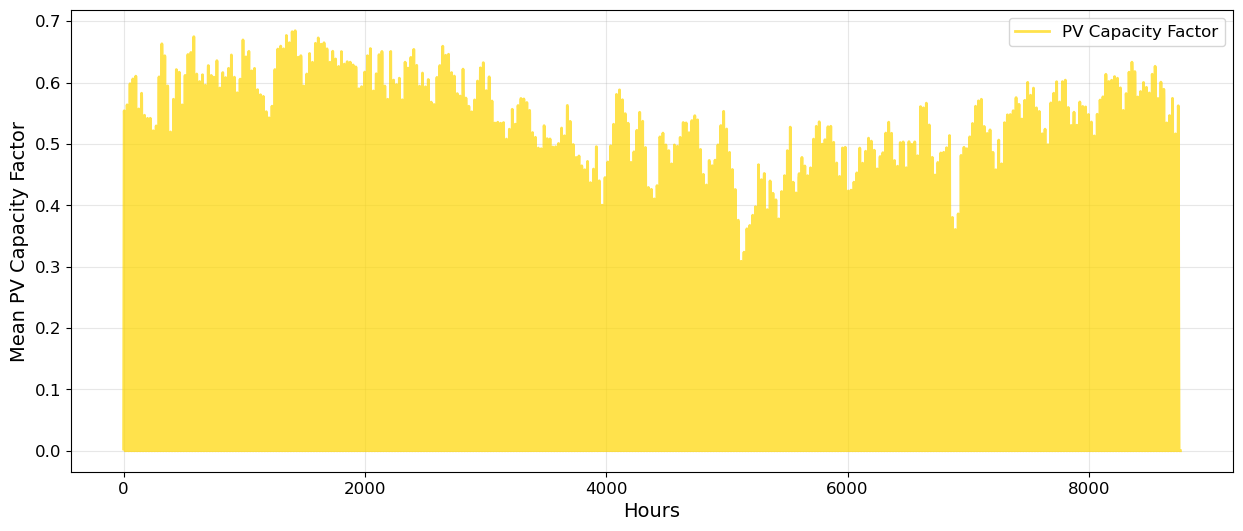

In [ ]:
pv_profile = xr.open_dataarray("Cutouts_atlite/Laos5AVG_pv.nc")
# Set hour limit (e.g., first week = 168 hours)
hour_limit = 8760

# Calculate mean across spatial dimensions
pv_mean = pv_profile.mean(dim='hexagon')

# Create hour index
hours = np.arange(hour_limit)

# Create plot
plt.figure(figsize=(15, 6))
plt.plot(hours, pv_mean[:hour_limit], 
         color='#ffd700',  # golden yellow for solar
         label='PV Capacity Factor', 
         alpha=0.7, 
         linewidth=2)

# Customize plot
plt.xlabel('Hours', fontsize=14)
plt.ylabel('Mean PV Capacity Factor', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

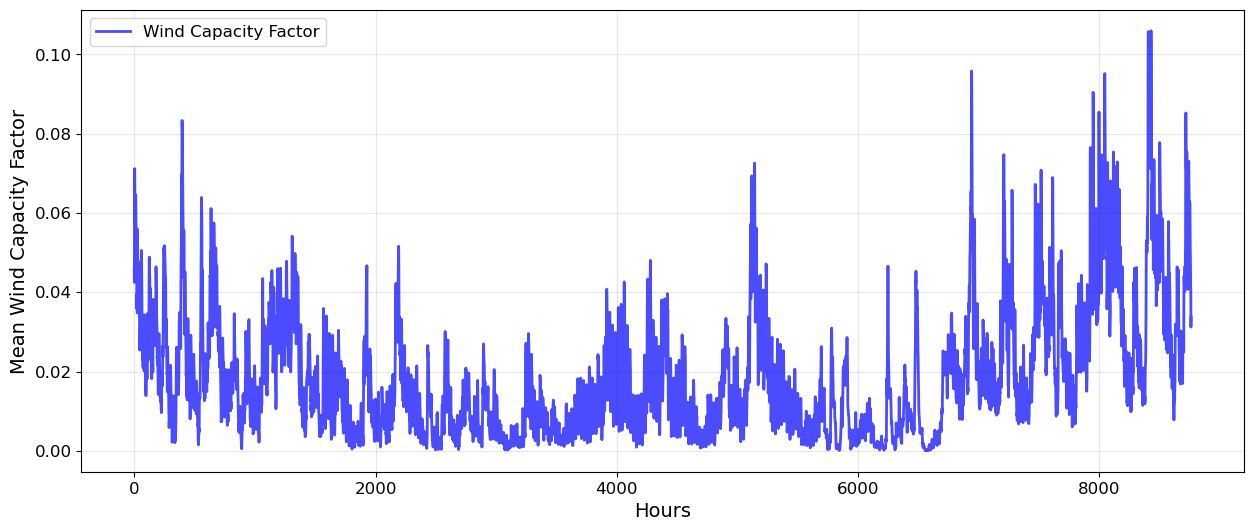

In [19]:
wind_profile = xr.open_dataarray("Cutouts_atlite/Laos5AVG_wind.nc")
# Set hour limit (e.g., first week = 168 hours)
hour_limit = 8760

# Calculate mean across spatial dimensions
wind_mean = wind_profile.mean(dim='hexagon')

# Create hour index
hours = np.arange(hour_limit)

# Create plot
plt.figure(figsize=(15, 6))
plt.plot(hours, wind_mean[:hour_limit], 
         color='blue',  # golden yellow for solar
         label='Wind Capacity Factor', 
         alpha=0.7, 
         linewidth=2)

# Customize plot
plt.xlabel('Hours', fontsize=14)
plt.ylabel('Mean Wind Capacity Factor', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## Try out

In [7]:
def delete_specific_day(data, year, month, day):
    """
    Delete data corresponding to a specific day from a time-indexed xarray.DataArray.

    Args:
        data (xarray.DataArray): Time-indexed dataset (e.g., hourly data for a year).
        year (int): Year of the day to remove.
        month (int): Month of the day to remove.
        day (int): Day of the month to remove.

    Returns:
        xarray.DataArray: The dataset with the specified day removed.
    """
    # Convert the time index to pandas.Timestamp for easy filtering
    time_index = data["time"].to_index()

    # Create a mask to exclude rows corresponding to the specified date
    mask = ~((time_index.year == year) & (time_index.month == month) & (time_index.day == day))

    # Apply the mask to the DataArray
    return data.sel(time=mask)


In [8]:
cutout_files = [f"Cutouts_atlite/Laos{i}Y.nc" for i in range(1, 6)]

# Calculate runoff for each year and store in a list
runoff_list = []
for file in cutout_files:
    cutout = atlite.Cutout(file)
    runoff = cutout.hydro(
        plants=location_hydro,
        hydrobasins=laos_hydrobasins,
        per_unit=True  # Normalize output per unit area
    )
    if "2" in file:  # Adjust this condition based on your file naming convention
            runoff = delete_specific_day(runoff, year=2020, month=2, day=29)
    runoff = runoff.isel(time=slice(0, 8760))

    runoff_list.append(runoff)



c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


In [9]:
# Combine runoff data from all years into a single DataFrame
hourly_runoff_df = pd.DataFrame()

for runoff in runoff_list:
    # Convert runoff (xarray.DataArray) to pandas DataFrame
    runoff_df = runoff.to_dataframe(name="runoff").reset_index()  # Flatten xarray to a DataFrame
    hourly_runoff_df = pd.concat([hourly_runoff_df, runoff_df], ignore_index=True)

In [10]:
# Step 1: Extract month, day, and hour from the 'time' column
hourly_runoff_df["month"] = hourly_runoff_df["time"].dt.month
hourly_runoff_df["day"] = hourly_runoff_df["time"].dt.day
hourly_runoff_df["hour"] = hourly_runoff_df["time"].dt.hour


In [11]:
hourly_runoff_df

,plant,time,runoff,month,day,hour
0,0,2019-01-01 00:00:00,2.931389e+06,1,1,0
1,0,2019-01-01 01:00:00,2.944661e+06,1,1,1
2,0,2019-01-01 02:00:00,2.966098e+06,1,1,2
3,0,2019-01-01 03:00:00,3.067301e+06,1,1,3
4,0,2019-01-01 04:00:00,3.104339e+06,1,1,4
...,...,...,...,...,...,...
5080795,115,2023-12-31 19:00:00,4.305927e+07,12,31,19
5080796,115,2023-12-31 20:00:00,4.294784e+07,12,31,20
5080797,115,2023-12-31 21:00:00,4.295726e+07,12,31,21
5080798,115,2023-12-31 22:00:00,4.294054e+07,12,31,22


In [12]:
# Step 2: Group by plant, month, day, and hour to calculate the average
averaged_runoff_grouped = (
    hourly_runoff_df.groupby(["plant", "month", "day", "hour"])["runoff"]
    .mean()
    .reset_index()
)

averaged_runoff_grouped

,plant,month,day,hour,runoff
0,0,1,1,0,4.332495e+06
1,0,1,1,1,4.304853e+06
2,0,1,1,2,4.315632e+06
3,0,1,1,3,4.336991e+06
4,0,1,1,4,4.332769e+06
...,...,...,...,...,...
1016155,115,12,31,19,4.021490e+07
1016156,115,12,31,20,3.998655e+07
1016157,115,12,31,21,3.999896e+07
1016158,115,12,31,22,4.147189e+07


In [13]:
averaged_runoff_grouped["time"] = pd.to_datetime(
    "2023-" + averaged_runoff_grouped["month"].astype(str) + "-" +
    averaged_runoff_grouped["day"].astype(str) + " " +
    averaged_runoff_grouped["hour"].astype(str) + ":00:00",
    errors="coerce"
)
averaged_runoff_grouped

,plant,month,day,hour,runoff,time
0,0,1,1,0,4.332495e+06,2023-01-01 00:00:00
1,0,1,1,1,4.304853e+06,2023-01-01 01:00:00
2,0,1,1,2,4.315632e+06,2023-01-01 02:00:00
3,0,1,1,3,4.336991e+06,2023-01-01 03:00:00
4,0,1,1,4,4.332769e+06,2023-01-01 04:00:00
...,...,...,...,...,...,...
1016155,115,12,31,19,4.021490e+07,2023-12-31 19:00:00
1016156,115,12,31,20,3.998655e+07,2023-12-31 20:00:00
1016157,115,12,31,21,3.999896e+07,2023-12-31 21:00:00
1016158,115,12,31,22,4.147189e+07,2023-12-31 22:00:00


In [14]:

# Step 4: Pivot the DataFrame to have plants as columns
pivoted_runoff_df = averaged_runoff_grouped.pivot(index="time", columns="plant", values="runoff")

# Step 5: Ensure the time index is complete for 2023 (non-leap year, 8760 hours)
time_index_2023 = pd.date_range(start="2023-01-01", end="2023-12-31 23:00", freq="H")
pivoted_runoff_df = pivoted_runoff_df.reindex(time_index_2023)

# Step 6: Convert the DataFrame into an xarray.DataArray
runoff_xr = xr.DataArray(
    data=pivoted_runoff_df.values,
    dims=["time", "plant"],
    coords={
        "time": time_index_2023,
        "plant": pivoted_runoff_df.columns
    }
)
runoff_xr = runoff_xr.transpose("plant", "time")


C:\Users\ls2823\AppData\Local\Temp\ipykernel_100956\687811280.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index_2023 = pd.date_range(start="2023-01-01", end="2023-12-31 23:00", freq="H")


In [15]:
runoff_xr.to_netcdf("Cutouts_atlite/Laos5AVG_Runoff_30.nc")

## PV

In [194]:
cutout_files = [f"Cutouts_atlite/Laos{i}Y.nc" for i in range(1, 6)]

# Calculate pv_profile for each year and store in a list
pv_profile_list = []
for file in cutout_files:
    cutout = atlite.Cutout(file)
    
    pv_profile = cutout.wind(
        # Changed turbine type - was Vestas_V80_2MW_gridstreamer in first run
        # Other option being explored: NREL_ReferenceTurbine_2020ATB_4MW, Enercon_E126_7500kW
        turbine = 'Vestas_V80_2MW_gridstreamer',
        layout = layout,
        shapes = hexagons,
        per_unit = True
        )
    pv_profile = pv_profile.rename(dict(dim_0='hexagon'))
    
    if "2" in file:  # Adjust this condition based on your file naming convention
            pv_profile = delete_specific_day(pv_profile, year=2020, month=2, day=29)
    pv_profile = pv_profile.isel(time=slice(0, 8760))

    pv_profile_list.append(pv_profile)



c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\atlite\resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\atlite\resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\atlite\resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\atlite\resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)


In [202]:
# Combine pv_profile data from all years into a single DataFrame
hourly_pv_profile_df = pd.DataFrame()

for pv_profile in pv_profile_list:
    # Convert pv_profile (xarray.DataArray) to pandas DataFrame
    pv_profile_df = pv_profile.to_dataframe(name="pv_profile").reset_index()  # Flatten xarray to a DataFrame
    hourly_pv_profile_df = pd.concat([hourly_pv_profile_df, pv_profile_df], ignore_index=True)

In [203]:
# Step 1: Extract month, day, and hour from the 'time' column
hourly_pv_profile_df["month"] = hourly_pv_profile_df["time"].dt.month
hourly_pv_profile_df["day"] = hourly_pv_profile_df["time"].dt.day
hourly_pv_profile_df["hour"] = hourly_pv_profile_df["time"].dt.hour


In [204]:
hourly_pv_profile_df

,time,hexagon,pv_profile,month,day,hour
0,2019-01-01 00:00:00,0,0.000000,1,1,0
1,2019-01-01 00:00:00,1,0.000000,1,1,0
2,2019-01-01 00:00:00,2,0.000000,1,1,0
3,2019-01-01 00:00:00,3,0.045010,1,1,0
4,2019-01-01 00:00:00,4,0.478489,1,1,0
...,...,...,...,...,...,...
49756795,2023-12-31 23:00:00,1131,0.000000,12,31,23
49756796,2023-12-31 23:00:00,1132,0.000000,12,31,23
49756797,2023-12-31 23:00:00,1133,0.000000,12,31,23
49756798,2023-12-31 23:00:00,1134,0.000000,12,31,23


In [198]:
# Step 2: Group by plant, month, day, and hour to calculate the average
averaged_pv_grouped = (
    hourly_pv_profile_df.groupby(["hexagon", "month", "day", "hour"])["pv_profile"]
    .mean()
    .reset_index()
)

averaged_pv_grouped

,hexagon,month,day,hour,pv_profile
0,0,1,1,0,0.000016
1,0,1,1,1,0.002941
2,0,1,1,2,0.000000
3,0,1,1,3,0.000000
4,0,1,1,4,0.000000
...,...,...,...,...,...
9951355,1135,12,31,19,0.183959
9951356,1135,12,31,20,0.179751
9951357,1135,12,31,21,0.181325
9951358,1135,12,31,22,0.133965


In [199]:
averaged_pv_grouped["time"] = pd.to_datetime(
    "2023-" + averaged_pv_grouped["month"].astype(str) + "-" +
    averaged_pv_grouped["day"].astype(str) + " " +
    averaged_pv_grouped["hour"].astype(str) + ":00:00",
    errors="coerce"
)
averaged_pv_grouped

,hexagon,month,day,hour,pv_profile,time
0,0,1,1,0,0.000016,2023-01-01 00:00:00
1,0,1,1,1,0.002941,2023-01-01 01:00:00
2,0,1,1,2,0.000000,2023-01-01 02:00:00
3,0,1,1,3,0.000000,2023-01-01 03:00:00
4,0,1,1,4,0.000000,2023-01-01 04:00:00
...,...,...,...,...,...,...
9951355,1135,12,31,19,0.183959,2023-12-31 19:00:00
9951356,1135,12,31,20,0.179751,2023-12-31 20:00:00
9951357,1135,12,31,21,0.181325,2023-12-31 21:00:00
9951358,1135,12,31,22,0.133965,2023-12-31 22:00:00


In [200]:

# Step 4: Pivot the DataFrame to have plants as columns
pivoted_pv_df = averaged_pv_grouped.pivot(index="time", columns="hexagon", values="pv_profile")

# Step 5: Ensure the time index is complete for 2023 (non-leap year, 8760 hours)
time_index_2023 = pd.date_range(start="2023-01-01", end="2023-12-31 23:00", freq="H")
pivoted_pv_df = pivoted_pv_df.reindex(time_index_2023)

# Step 6: Convert the DataFrame into an xarray.DataArray
pv_xr = xr.DataArray(
    data=pivoted_pv_df.values,
    dims=["time", "hexagon"],
    coords={
        "time": time_index_2023,
        "hexagon": pivoted_pv_df.columns
    }
)
pv_xr = pv_xr.transpose("hexagon", "time")


C:\Users\ls2823\AppData\Local\Temp\ipykernel_7416\3914915674.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index_2023 = pd.date_range(start="2023-01-01", end="2023-12-31 23:00", freq="H")


In [201]:
pv_xr

<xarray.DataArray (hexagon: 1136, time: 8760)> Size: 80MB
array([[1.55943418e-05, 2.94066025e-03, 0.00000000e+00, ...,
        1.91857591e-05, 0.00000000e+00, 1.32735536e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.39719566e-02, 4.66606618e-02, 5.22466015e-02, ...,
        4.90994985e-02, 3.20487841e-02, 3.41141680e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36853729e-01, 1.76914454e-01, 3.47927813e-01, ...,
        1.81324600e-01, 1.33965313e-01, 1.54048662e-01]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
  * hexagon  (hexagon) int64 9kB 0 1 2 3 4 5 6 ... 1130 1131 1132 1133 1134 1135

In [207]:
pv_xr.to_netcdf("Cutouts_atlite/Laos5AVG_wind.nc")

: 

## WIND

In [206]:
cutout = atlite.Cutout('Cutouts_atlite/Laos1Y.nc')
wind = cutout.wind(
        # Changed turbine type - was Vestas_V80_2MW_gridstreamer in first run
        # Other option being explored: NREL_ReferenceTurbine_2020ATB_4MW, Enercon_E126_7500kW
        turbine = 'Vestas_V80_2MW_gridstreamer',
        layout = layout,
        shapes = hexagons,
        per_unit = True
        )
wind

c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\atlite\resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray (time: 8784, dim_0: 1136)> Size: 80MB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.62243850e-02, 0.00000000e+00, 4.27350482e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.17788378e-02, 0.00000000e+00, 2.83574420e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.53907781e-02, 0.00000000e+00, 3.38463146e-01],
       ...,
       [1.13454163e-02, 0.00000000e+00, 0.00000000e+00, ...,
        5.73202269e-03, 0.00000000e+00, 6.18875816e-02],
       [7.75595162e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.81149156e-02],
       [4.65777512e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.65976590e-02]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2019-01-01 ... 2020-01-01T23:00:00
  * dim_0    (dim_0) int64 9kB 0 1 2 3 4 5 6 ... 1130 1131 1132 1133 1134 1135
Attributes:
    units:    p.u.

### Old runoff

In [140]:
cutout = atlite.Cutout('Cutouts_atlite/Laos1Y.nc')
layout = cutout.uniform_layout()

runoff = cutout.hydro(
        plants=location_hydro,
        hydrobasins= laos_hydrobasins,
        per_unit=True                    # Normalize output per unit area
    )

c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


In [161]:
cutout

<Cutout "Laos1Y">
 x = 100.25 ⟷ 107.50, dx = 0.25
 y = 14.00 ⟷ 22.50, dy = 0.25
 time = 2019-01-01 ⟷ 2020-01-01, dt = h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

## Generic function

In [162]:
def calculate_average_over_cutouts(
    cutout_files,
    feature,
    layout=None,
    shapes=None,
    plants=None,
    hydrobasins=None,
    normalize_per_unit=False,
    delete_leap_day=False
):
    """
    Generic function to calculate the average of a feature (e.g., runoff, wind, PV) across multiple cutout files.
    
    Args:
        cutout_files (list): List of file paths for the cutouts.
        feature (str): The feature to calculate ('runoff', 'wind', 'pv').
        layout (pd.DataFrame, optional): Layout for PV or wind features.
        shapes (gpd.GeoDataFrame, optional): Shapes for PV or wind features.
        plants (GeoDataFrame, optional): Plant data for runoff calculation.
        hydrobasins (GeoDataFrame, optional): Hydrobasins data for runoff calculation.
        normalize_per_unit (bool, optional): Whether to normalize the output per unit area.
        delete_leap_day (bool, optional): Whether to delete February 29 from leap years.
    
    Returns:
        xarray.DataArray: Averaged feature data across years as an xarray.DataArray.
    """
    feature_list = []
    
    for file in cutout_files:
        cutout = atlite.Cutout(file)
        
        # Calculate the feature based on type
        if feature == "runoff":
            data = cutout.hydro(
                plants=plants,
                hydrobasins=hydrobasins,
                per_unit=normalize_per_unit
            )
        elif feature == "wind":
            data = cutout.wind(
                turbine='Vestas_V80_2MW_gridstreamer',
                layout=layout,
                shapes=shapes,
                per_unit=normalize_per_unit
            )
        elif feature == "pv":
            data = cutout.pv(
                panel='CSi',
                orientation='latitude_optimal',
                layout=layout,
                shapes=shapes,
                per_unit=normalize_per_unit
            )
        else:
            raise ValueError(f"Unknown feature: {feature}")
        
        # Handle leap years if necessary
        if delete_leap_day:
            data = delete_specific_day(data, year=2020, month=2, day=29)
        
        # Ensure the time dimension has 8760 hours
        data = data.isel(time=slice(0, 8760))
        
        feature_list.append(data)
    
    # Combine all years into a single DataFrame
    combined_df = pd.DataFrame()
    
    for data in feature_list:
        data_df = data.to_dataframe(name=feature).reset_index()
        combined_df = pd.concat([combined_df, data_df], ignore_index=True)
    
    # Process time to calculate the average over the years
    combined_df["month"] = combined_df["time"].dt.month
    combined_df["day"] = combined_df["time"].dt.day
    combined_df["hour"] = combined_df["time"].dt.hour
    
    averaged_df = (
        combined_df.groupby(["month", "day", "hour", "plant"])[feature]
        .mean()
        .reset_index()
    )
    
    # Create a 2023 time index
    averaged_df["time"] = pd.to_datetime(
        "2023-" + averaged_df["month"].astype(str) + "-" +
        averaged_df["day"].astype(str) + " " +
        averaged_df["hour"].astype(str) + ":00:00",
        errors="coerce"
    )
    
    # Pivot the DataFrame to create a time-series format
    pivoted_df = averaged_df.pivot(index="time", columns="plant", values=feature)
    time_index_2023 = pd.date_range(start="2023-01-01", end="2023-12-31 23:00", freq="H")
    pivoted_df = pivoted_df.reindex(time_index_2023)
    
    # Convert to xarray.DataArray
    feature_xr = xr.DataArray(
        data=pivoted_df.values,
        dims=["time", "plant"],
        coords={"time": time_index_2023, "plant": pivoted_df.columns}
    )
    
    return feature_xr.transpose("plant", "time")


In [ ]:
cutout_files = [f"Cutouts_atlite/Laos{i}Y.nc" for i in range(1, 6)]


In [163]:
runoff_xr = calculate_average_over_cutouts(
    cutout_files=cutout_files,
    feature="runoff",
    plants=location_hydro,
    hydrobasins=laos_hydrobasins,
    normalize_per_unit=True,
    delete_leap_day=True # Has to be true
)

c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
C:\Users\ls2823\AppData\Local\Temp\ipyke

In [164]:
runoff_xr

<xarray.DataArray (plant: 103, time: 8760)> Size: 7MB
array([[ 4332494.82034896,  4304852.64974334,  4315632.16386446, ...,
         4485925.77239597,  4548882.683571  ,  4512720.96633105],
       [  410127.44004107,   410225.84392749,   410151.56522381, ...,
          438035.55995396,   435241.17190689,   433922.34138981],
       [ 9483046.92923011, 10867320.91593014,  9797435.72808936, ...,
         8715924.24375688,  8564034.42646914,  8958483.88551007],
       ...,
       [   82212.22206406,    83014.10701412,    83984.89805931, ...,
           78565.48228786,    78206.87278469,    78189.30810056],
       [  132845.77745228,   132562.4817414 ,   132408.06217902, ...,
          133564.66824993,   134372.75916924,   134627.9347751 ],
       [  198071.55528546,   197072.61615463,   198424.61633074, ...,
          204771.74549576,   205430.29220108,   205765.52325462]])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
  * plant    (plant) int64 824B 0 1 2 3 4 5 6 7 8 ... 95 96 97 98 99 100 101 102

### Plot

In [12]:
def hydropower_potential(eta,flowrate,head):
    '''
    Calculate hydropower potential in Megawatts

    Parameters
    ----------
    eta : float
        Efficiency of the hydropower plant.
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.

    Returns
    -------
    float
        Hydropower potential in Megawatts (MW).
    '''
    rho = 997 # kg/m3; Density of water
    g = physical_constants['standard acceleration of gravity'][0] # m/s2; Based on the CODATA constants 2018
    Q = flowrate / 3600 # transform flowrate per h into flowrate per second
    return (eta * rho * g * Q * head) / (1000 * 1000) # MW

def hydropower_potential_with_capacity(flowrate, head, capacity, eta):
    '''
    Calculate the hydropower potential considering the capacity limit

    Parameters
    ----------
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.
    capacity : float
        Maximum hydropower capacity in Megawatts (MW).
    eta : float
        Efficiency of the hydropower plant.

    Returns
    -------
    xarray DataArray
        Capacity factor, which is the limited potential divided by the capacity.
    '''
    potential = hydropower_potential(flowrate, head, eta)
    limited_potential = xr.where(potential > capacity, capacity, potential)
    capacity_factor = limited_potential / capacity
    return capacity_factor